Modelos Preditivos:
-

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:

# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_unique.pkl')

# Exibindo as primeiras linhas do DataFrame
df.head()


,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,...,occupation_type,score_checks,score_date,start_hour,default,credit_card_initial_line,payment,date,credit_line,spends
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311.861.179.261.000,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,198.40,2016-09-30,2180.0,198.40
1,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311.861.179.261.000,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,149.94,2016-10-31,2368.0,145.49
2,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311.861.179.261.000,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,10.02,2016-11-30,3103.0,10.02
3,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311.861.179.261.000,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,38.48,2016-12-31,2430.0,278.05
4,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311.861.179.261.000,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,2888.77,2017-01-31,2650.0,2888.77


Tratamento da variável target:
-

In [25]:
print("Contagem de valores únicos na coluna 'default':")
print(df['default'].value_counts(dropna=False))


Contagem de valores únicos na coluna 'default':
default
False    312249
True      63249
nan       28767
Name: count, dtype: int64


In [26]:
df['default'] = df['default'].map({'False': False, 'True': True, False: False, True: True})

In [27]:
df['default'] = df['default'].map({False: 0, True: 1})

In [28]:
df = df[df['default'].notna()]


Treino e teste:
- 

In [29]:
# Seleção das variáveis
features = [
        'age', 'amt_active_loan', 'channel', 'ext_score_1', 'ext_score_2',
       'ext_score_3', 'ext_score_4', 'flag_document_A', 'gender', 'ids',
       'income', 'occupation_type', 'score_checks', 'score_date', 'start_hour',
       'credit_card_initial_line', 'payment', 'date', 'credit_line',
       'spends'
]

In [30]:
# Remover linhas onde a variável alvo é nula
df = df[df['default'].notna()]

In [31]:
# Definir X e y
X = df[features]
y = df['default']

In [32]:
# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Pré-processamento:
-

In [33]:
# Definir colunas por tipo

# Numéricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categóricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [34]:
# Transformação e Extração de partes da data (score_date)

for df_ in [X_train, X_test]:
    df_['score_year'] = df_['score_date'].dt.year
    df_['score_month'] = df_['score_date'].dt.month
    df_['score_day'] = df_['score_date'].dt.day

X_train.drop(columns='score_date', inplace=True)
X_test.drop(columns='score_date', inplace=True)

num_cols.extend(['score_year', 'score_month', 'score_day'])


In [35]:
# Criar Pré-processadores

# Pipeline para colunas numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para colunas categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinando pré-processadores
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [36]:
 # Pipeline com modelo baseline, testando a Regressão Logística


baseline_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'income',
                                                   'score_checks', 'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment', 'credit_line',
                                                   'spends', 'score_year',
                                                   'score_month',
                                                   'score_day']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['channel', 'ext_score_2',
                                                   'ext_score_3', 'ext_score_4',
                                                   'flag_document_A', 'gender',
                                                   'ids', 'occupation_type',
                                                   'date'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

        ColumnTransformer

Trata variáveis numéricas e categóricas separadamente:

- num (numéricas):

SimpleImputer: imputa valores ausentes (geralmente com média ou mediana).

StandardScaler: padroniza os dados (z-score).

- cat (categóricas):

SimpleImputer: imputa valores ausentes (geralmente com a moda).

OneHotEncoder: transforma categorias em variáveis dummies.


        LogisticRegression: 

Modelo de regressão logística com os seguintes parâmetros:

- max_iter=1000: aumenta o número máximo de iterações para convergência.

- class_weight='balanced': ajusta automaticamente o peso das classes com base em sua frequência, útil em datasets desbalanceados.

In [37]:
# Treinando o modelo de Random Forest

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'income',
                                                   'score_checks', 'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment', 'credit_line',
                                                   'spends', 'score_year',
                                                   'score_month',
                                                   'score_day']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['channel', 'ext_score_2',
                                                   'ext_score_3', 'ext_score_4',
                                                   'flag_document_A', 'gender',
                                                   'ids', 'occupation_type',
                                                   'date'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

        Preprocessor (pré-processador) | ColumnTransformer:

- Para variáveis numéricas (num):

SimpleImputer: preenche valores nulos.

StandardScaler: padroniza as variáveis.

- Para variáveis categóricas (cat):

SimpleImputer: preenche valores ausentes.

OneHotEncoder: transforma variáveis categóricas em dummies.

classifier:

        Modelo RandomForestClassifier:

- n_estimators=100: utiliza 100 árvores na floresta.

- random_state=42: garante reprodutibilidade dos resultados.

- class_weight='balanced': ajusta pesos das classes inversamente à sua frequência, lidando com desbalanceamento de forma automática.



In [38]:
# Avaliação dos modelos

y_pred_logreg = baseline_model.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

y_proba_logreg = baseline_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred_logreg))
print("ROC AUC:", roc_auc_score(y_test, y_proba_logreg))

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

=== Regressão Logística ===
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     93675
         1.0       0.96      0.96      0.96     18975

    accuracy                           0.99    112650
   macro avg       0.97      0.97      0.97    112650
weighted avg       0.99      0.99      0.99    112650

ROC AUC: 0.9943721384134098

=== Random Forest ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     93675
         1.0       1.00      0.91      0.95     18975

    accuracy                           0.98    112650
   macro avg       0.99      0.95      0.97    112650
weighted avg       0.99      0.98      0.98    112650

ROC AUC: 0.9944482218361426


        Regressão Logística
- Desempenho muito consistente entre precisão, recall e F1 para ambas as classes.

- Alta ROC AUC (0.99437) indica excelente separação entre as classes.

- Leve vantagem em recall da classe minoritária (1.0), capturando mais inadimplentes.

        Random Forest
- Precision da classe 1 perfeita (1.00): todos os positivos previstos realmente eram positivos.

- Porém, recall da classe 1 caiu para 0.91: perdeu parte dos verdadeiros inadimplentes.

- ROC AUC ligeiramente melhor (0.99445), mas a diferença é insignificante na prática.


        Insights:

Ambos os modelos tiveram boa performace com ROC AUC acima de 0.99.

Se detectar inadimplentes é prioridade, por exemplo, para evitar concessão de crédito arriscado, a Regressão Logística é preferível por ter maior recall (0.96 vs 0.91).

Se o custo de falsos positivos, como por exemplo, negar crédito a bons pagadores for mais crítico, a Random Forest, com sua precision de 1.00, pode ser uma boa escolha.




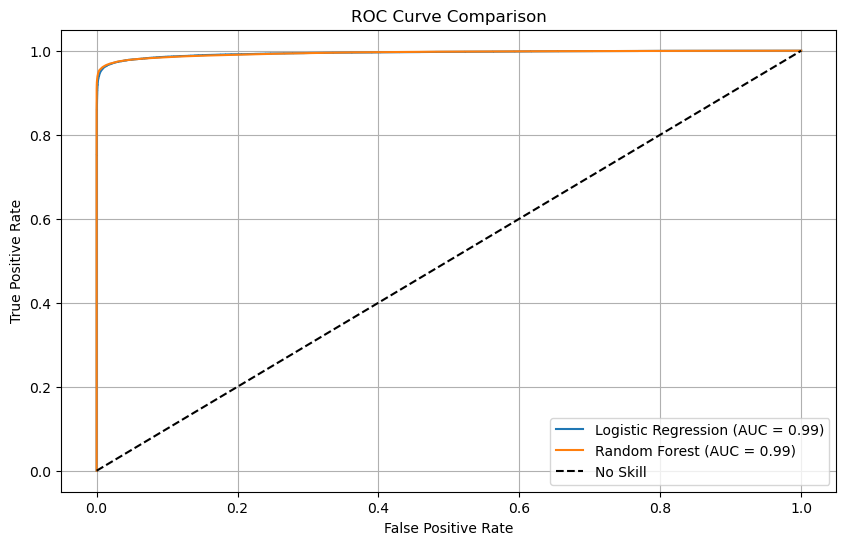

In [39]:
# Curva ROC

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_logreg):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})")
plt.plot([0, 1], [0, 1], "k--", label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

        Insights:

- As curvas da Regressão Logística (azul) e da Random Forest (laranja) estão praticamente sobrepostas, ambas muito próximas do canto superior esquerdo. Isso confirma que ambos os modelos têm desempenho excelente na separação das classes.

- A leve superioridade visual da Random Forest na parte inicial da curva é consistente com o leve ganho no ROC AUC (0.994448 vs. 0.994372), mas essa diferença é insignificante na prática.

- A curva ROC não favorece claramente nenhum dos dois modelos.

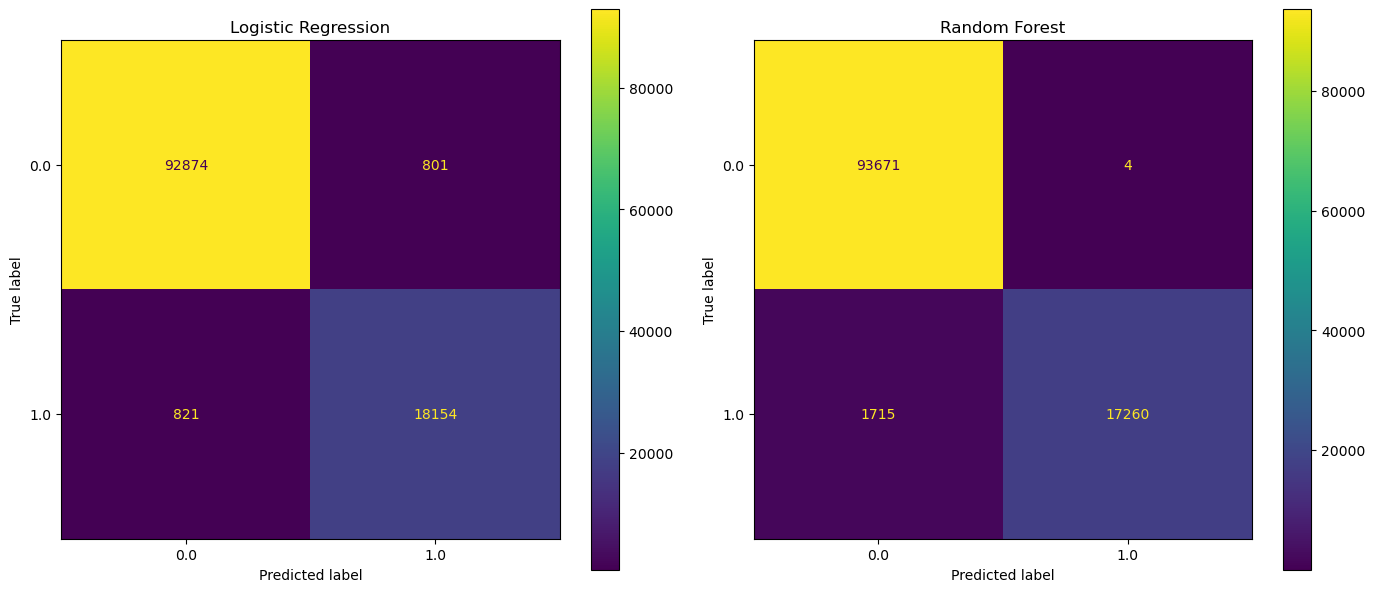

In [40]:
# Matriz de Confusão - Comparação direta entre os dois modelos em termos de erros de classificação

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, ax=axes[0])
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[1])
axes[1].set_title("Random Forest")

plt.tight_layout()
plt.show()

Cada célula representa:

- Verdadeiros negativos (TN): [0,0] — classe 0 corretamente prevista. RG = 92.874  | RF = 93.671

- Falsos positivos (FP): [0,1] — classe 0 prevista como 1 (erro). RG = 801  | RF = 4

- Falsos negativos (FN): [1,0] — classe 1 prevista como 0 (erro). RG = 821  | RF = 1.715

- Verdadeiros positivos (TP): [1,1] — classe 1 corretamente prevista. RG = 18.154  | RF = 17.260

        Regressãso Logística:
- Falsos negativos (FN): 821 → Casos de inadimplência que o modelo deixou passar.

        Random Forest:
Falsos negativos (FN): 1.715 → Quase dobro da Regressão Logística.


        Insights:
        
- Se seu objetivo é não liberar crédito para quem vai dar calote (evitar FP):

➤ Random Forest é muito mais conservador.

- Se o foco é não deixar bons clientes de fora (evitar FN):

➤ Regressão Logística pode ser preferida, pois rejeita menos inadimplentes por engano.


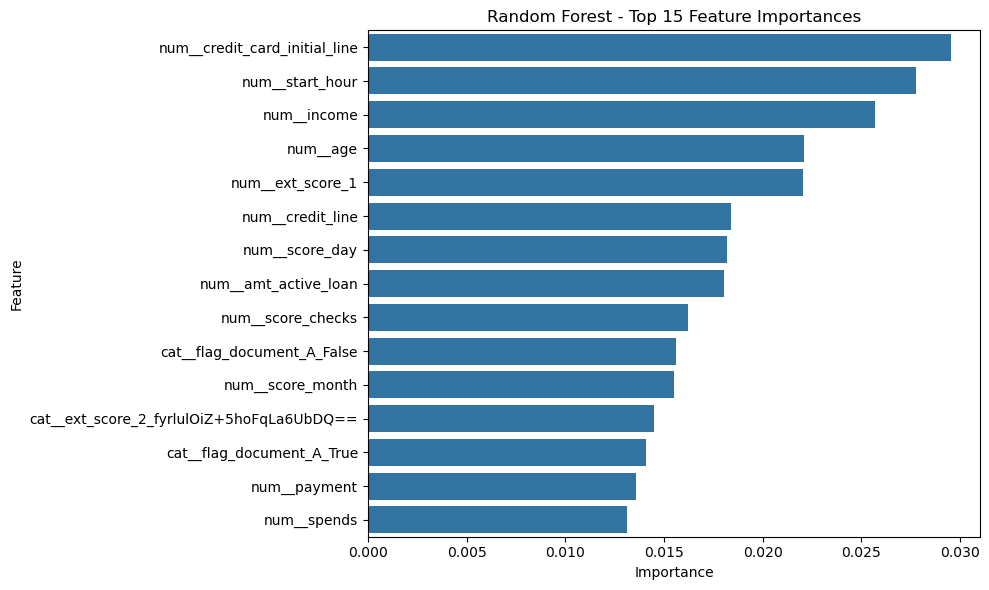

In [41]:
# Feature Importance (Random Forest)
rf_model = rf_pipeline.named_steps["classifier"]
importances = rf_model.feature_importances_
feature_names = rf_pipeline.named_steps["preprocessor"].get_feature_names_out()

importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df.head(15), x="Importance", y="Feature")
plt.title("Random Forest - Top 15 Feature Importances")
plt.tight_layout()
plt.show()

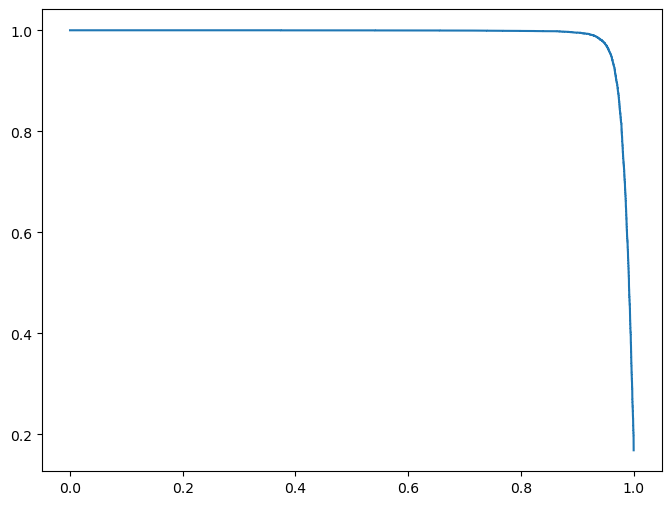

In [44]:
# Precision-Recall Curve (Para dados desbalanceados):

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Regressão Logística
y_scores_lr = baseline_model.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_scores_lr)
ap_lr = average_precision_score(y_test, y_scores_lr)
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.2f})')

        Insights:

Essa curva Precision-Recall indica que seu modelo está com desempenho muito bom.
- Alta Precisão (Precision): poucos falsos positivos.

- Alta Revocação (Recall): poucos falsos negativos.        